In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from lifelines import KaplanMeierFitter, CoxPHFitter
import tqdm
from models import create_compound_model_from_info, create_pytorch_model_from_info, MultiHead
import json
from misc import download_data_dir
import os

In [101]:
dropbox_url = 'https://www.dropbox.com/scl/fo/0zbnyynf5igdorbh6veqh/AE8PiJDZ5FB2Qbu_KiAF9W4?rlkey=km43xr7dpfssgdjcbev21ddb2&dl=1'
download_data_dir(dropbox_url, save_dir='/app/model_data')

In [3]:
dropbox_url = 'https://www.dropbox.com/scl/fo/y36aiinfbsf6rymzj1qh4/ACjkhRE_Ig_IBwlrH4Tl_Ug?rlkey=4s5imazvcoktgk83lig8rypjw&dl=1'
download_data_dir(dropbox_url, save_dir='/app/finetune_data')

In [2]:
# generalized function to run grid search with custom objective
def prep_surv_y(survival_column, event_column):
    """
    Function for formatting survival data as input to sksurv models.
    Args:
        survival_column: list of survival times
        event_column: list of event indicators (0 for censored, 1 for event)
    """
    surv_y = np.array([(event_column.iloc[i], survival_column.iloc[i]) for i in range(len(survival_column))], dtype=[('status', bool), ('time', float)])
    # surv_y = np.array([(event_column[i], survival_column[i]) for i in range(len(survival_column))], dtype=[('status', bool), ('time', float)])
    return surv_y

def create_data_dict(data_dir,set_name,os_col,event_col,data_dict=None):
    if data_dict is None:
        data_dict = {}
    X_path = f'{data_dir}/X_finetune_{set_name}.csv'
    y_path = f'{data_dir}/y_finetune_{set_name}.csv'
    X = pd.read_csv(X_path, index_col=0)
    y = pd.read_csv(y_path, index_col=0)
    not_nan = ~y[os_col].isna()
    data_dict[set_name] = {"X": X.loc[not_nan],
                           "y": prep_surv_y(y.loc[not_nan,os_col], y.loc[not_nan,event_col]),
                           'os_col':os_col,
                           'event_col':event_col,
                           'X_file':X_path,
                           'y_file':y_path}
    return data_dict

In [3]:
input_dir = '/app/model_data'
data_dir = '/app/finetune_data'

data_dict =create_data_dict(data_dir,'trainval','OS','OS_Event')
data_dict =create_data_dict(data_dir,'test','OS','OS_Event',data_dict)

In [4]:
# Load the trained model
# model_info = json.load(open(f'{input_dir}/VAE__Cox_OS_info.json'))
# model_state = torch.load(f'{input_dir}/VAE__Cox_OS_state.pt')

model_info = json.load(open(f'{input_dir}/Model_2925 info.json'))
model_state = torch.load(f'{input_dir}/Model_2925 state.pt')

model_trained = create_pytorch_model_from_info(model_info, model_state)


In [5]:
y_trainval = pd.read_csv(os.path.join(data_dir, 'y_finetune_trainval.csv'), index_col=0)
pred_trainval = model_trained.predict(data_dict['trainval']["X"].to_numpy()).flatten()
y_trainval['predicted hazard'] = pred_trainval
y_trainval['predicted survival'] = -1*pred_trainval

/app/mz_embed_engine/ml/models.py:1318: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_vars = torch.tensor(other_vars, dtype=torch.float32)


In [6]:
y_test = pd.read_csv(os.path.join(data_dir, 'y_finetune_test.csv'), index_col=0)
pred_test = model_trained.predict(data_dict['test']["X"].to_numpy()).flatten()

y_test['predicted hazard'] = pred_test
y_test['predicted survival'] = -1*pred_test

/app/mz_embed_engine/ml/models.py:1318: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_vars = torch.tensor(other_vars, dtype=torch.float32)


## Prognostic Marker #1

In [17]:
prog_name = 'PROG1'
low_score_th = -1*1.4268135 
intermediate_score_th = -1* -5.127913

print('low score threshold:', low_score_th)
print('intermediate score threshold:', intermediate_score_th)

y_trainval[prog_name] = 'NA'
y_trainval.loc[y_trainval['predicted survival'] <= low_score_th, prog_name] = 'POOR'
y_trainval.loc[(y_trainval['predicted survival'] > low_score_th) & (y_trainval['predicted survival'] <= intermediate_score_th), prog_name] = 'INTERMEDIATE'
y_trainval.loc[y_trainval['predicted survival'] > intermediate_score_th, prog_name] = 'FAVORABLE'

y_trainval[prog_name].value_counts().sort_index()

low score threshold: -1.4268135
intermediate score threshold: 5.127913


PROG1
FAVORABLE       216
INTERMEDIATE    200
POOR            176
Name: count, dtype: int64

In [18]:
# get the percentages distribution
y_trainval[prog_name].value_counts()/y_trainval[prog_name].value_counts().sum()

PROG1
FAVORABLE       0.364865
INTERMEDIATE    0.337838
POOR            0.297297
Name: count, dtype: float64

In [19]:

y_trainval['MSKCC'].value_counts().sort_index()/y_trainval['MSKCC'].value_counts().sum()

MSKCC
FAVORABLE       0.344595
INTERMEDIATE    0.472973
POOR            0.182432
Name: count, dtype: float64

In [20]:
y_trainval['IMDC'].value_counts().sort_index()/y_trainval['IMDC'].value_counts().sum()

IMDC
FAVORABLE       0.153716
INTERMEDIATE    0.596284
NOT REPORTED    0.038851
POOR            0.211149
Name: count, dtype: float64

In [21]:

y_test.loc[y_test['predicted survival'] <= low_score_th, prog_name] = 'POOR'
y_test.loc[(y_test['predicted survival'] > low_score_th) & (y_test['predicted survival'] <= intermediate_score_th), prog_name] = 'INTERMEDIATE'
y_test.loc[y_test['predicted survival'] > intermediate_score_th, prog_name] = 'FAVORABLE'

y_test[prog_name].value_counts().sort_index()

PROG1
FAVORABLE       31
INTERMEDIATE    94
POOR            24
Name: count, dtype: int64

In [22]:
y_test['MSKCC'].value_counts().sort_index()

MSKCC
FAVORABLE       53
INTERMEDIATE    65
POOR            31
Name: count, dtype: int64

In [23]:
y_test['IMDC'].value_counts().sort_index()

IMDC
FAVORABLE       23
INTERMEDIATE    86
NOT REPORTED     6
POOR            34
Name: count, dtype: int64

## Prognostic Marker most similar to IMDC in the Test Data

In [24]:
imdc_counts = y_test['IMDC'].value_counts().sort_index()
imdc_counts = imdc_counts[['FAVORABLE', 'INTERMEDIATE', 'POOR']].copy()

In [42]:
low_score_per = imdc_counts.loc['POOR']/imdc_counts.sum()
intermediate_score_per = imdc_counts.loc['INTERMEDIATE']/imdc_counts.sum() + low_score_per
# prog_name = 'PROG2925C'
prog_name = 'PROG2'

y_test_imdc = y_test[y_test['IMDC ORDINAL'].notna()].copy()

y_test_imdc[prog_name] = 'NA'

low_score_th = np.percentile(y_test_imdc['predicted survival'], low_score_per*100)
intermediate_score_th = np.percentile(y_test_imdc['predicted survival'], intermediate_score_per*100)

In [43]:
y_test_imdc.loc[y_test['predicted survival'] <= low_score_th, prog_name] = 'POOR'
y_test_imdc.loc[(y_test['predicted survival'] > low_score_th) & (y_test_imdc['predicted survival'] <= intermediate_score_th), prog_name] = 'INTERMEDIATE'
y_test_imdc.loc[y_test['predicted survival'] > intermediate_score_th, prog_name] = 'FAVORABLE'

y_test_imdc[prog_name].value_counts().sort_index()

PROG2
FAVORABLE       23
INTERMEDIATE    86
POOR            34
Name: count, dtype: int64

In [44]:
y_trainval.loc[y_trainval['predicted survival'] <= low_score_th, prog_name] = 'POOR'
y_trainval.loc[(y_trainval['predicted survival'] > low_score_th) & (y_trainval['predicted survival'] <= intermediate_score_th), prog_name] = 'INTERMEDIATE'
y_trainval.loc[y_trainval['predicted survival'] > intermediate_score_th, prog_name] = 'FAVORABLE'

In [45]:
y_test.loc[y_test['predicted survival'] <= low_score_th, prog_name] = 'POOR'
y_test.loc[(y_test['predicted survival'] > low_score_th) & (y_test['predicted survival'] <= intermediate_score_th), prog_name] = 'INTERMEDIATE'
y_test.loc[y_test['predicted survival'] > intermediate_score_th, prog_name] = 'FAVORABLE'

y_test[prog_name].value_counts().sort_index()

PROG2
FAVORABLE       23
INTERMEDIATE    89
POOR            37
Name: count, dtype: int64

## KM comparison

In [46]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from lifelines import CoxPHFitter

from lifelines.utils import restricted_mean_survival_time
from lifelines.statistics import logrank_test
import warnings
# from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import restricted_mean_survival_time


cmap = cm.get_cmap('Dark2')
# create a custom colormap with the 3rd color removed

k=3
reg_cmp = cm.get_cmap('tab10')
colors = cmap(np.arange(cmap.N))
colors = np.vstack((colors[0:k,:]))
newcmp = ListedColormap(colors, name=f'Dark2_{k}')

output_dir = '/app/mz_embed_engine/output'
os.makedirs(output_dir, exist_ok=True)

/tmp/ipykernel_906308/2227601112.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Dark2')
/tmp/ipykernel_906308/2227601112.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  reg_cmp = cm.get_cmap('tab10')


In [62]:
val_col = 'PROG1'
# val_col = 'IMDC'

# os_col = 'PFS'
# cens_col = 'PFS_Event'
os_col = 'OS'
cens_col = 'OS_Event'

# y_data = y_trainval.copy()
# y_name = 'TrainVal'

y_data = y_test.copy()
y_name = 'Test'

y_data['Set'].value_counts()

Set
Test    149
Name: count, dtype: int64

OS col= OS
Cens col= OS_Event
Val col= PROG1
length of data df 149


Text(0, 0.5, 'Survival probability')

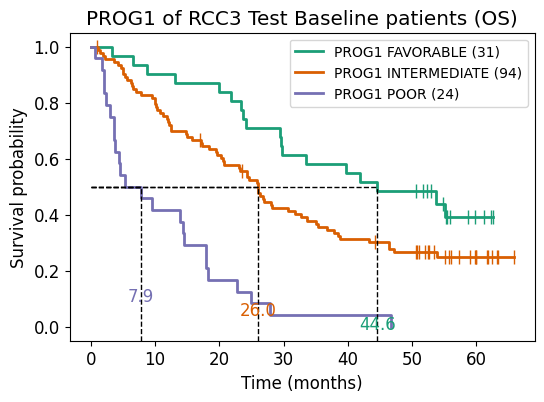

In [63]:


# y_data = y_test_imdc.copy()
# val_col = 'PROG-2925'
# val_col = 'PROG-2925B'
# val_col = 'PROG2925C'


kmf = KaplanMeierFitter()

# print("clust_col=", clust_col)
print("OS col=", os_col)
print("Cens col=", cens_col)
print("Val col=", val_col)

out_dict = {}
fig = plt.figure(figsize=(6,4))
plt.rcParams['font.size'] = 12

# data_df = y_data[(y_data['Set']=='Test') & (~y_data[val_col].isna()) & (y_data[val_col]!='NOT REPORTED')].copy()
data_df = y_data[(~y_data[val_col].isna()) & (y_data[val_col]!='NOT REPORTED')].copy()

print("length of data df", len(data_df))

lnw = 1
lnw2 = 2
median_survival_time_list =[]

os_list = []
cens_list = []


val_lvls = data_df[val_col].unique()
val_lvls = sorted(val_lvls,key=lambda x: x[0])
for i in val_lvls:
    df_s = data_df[data_df[val_col] == i].copy()
    os_vals = df_s[os_col]
    cens_vals = df_s[cens_col]
    #kmf.fit(os, event_observed=cens, label=f'NMF{k} Cluster {i}')
    #kmf.plot(ax=plt.gca(),show_censors=True,ci_show=False,linewidth=lnw)
    #median_survival_time_list.append(kmf.median_survival_time_)
    os_list.append(os_vals)
    cens_list.append(cens_vals)

for i,os_vals in enumerate(os_list):
    cens = cens_list[i]
    kmf.fit(os_vals, event_observed=cens, label=f'{val_col} {val_lvls[i]} ({len(os_vals)})')
    # kmf.fit(os_vals, event_observed=eval(f"os_cen{i+1}"), label=f'Cluster {i+1} ({len(os_vals)})')

    ax = kmf.plot(show_censors=True,ci_show=False,censor_styles={'marker':'|','ms':10},linewidth=lnw2,color=newcmp(i))
    median_survival_time = kmf.median_survival_time_
    median_survival_time_list.append(median_survival_time)

prev_t = 0
for i,t in enumerate(median_survival_time_list):
    ax.hlines(0.5,0,t,linestyles='--',color='k',linewidth=lnw)
    ax.axvline(t,ymax=0.5,ls='--',color='k',linewidth=lnw)
    ax.text(t,0.01+i*0.05,f'{t:.1f}',rotation=0,va='center',ha='center',color=newcmp(i),fontsize=12)





out_dict['mst'] = dict(zip(val_lvls,median_survival_time_list))

plt.title(f'{val_col} of RCC3 {y_name} Baseline patients ({os_col})')
# change the text size of the legend
plt.legend(fontsize=10)
plt.ylim(-.05,1.05)
plt.xlabel('Time (months)')
plt.ylabel('Survival probability')


In [59]:
median_survival_time_list

[7.326488706, 5.716632444, 2.102669405]

In [60]:

cox_ph_dict = {}

val_lvls = data_df[val_col].unique()
val_lvls = sorted(val_lvls,key=lambda x: x[0])
for i in val_lvls:
    for j in val_lvls:
        if i == j:
            continue
        df_s = data_df[(data_df[val_col] == i) | (data_df[val_col] == j)].copy()
        os_vals = df_s[os_col]
        cens_vals = df_s[cens_col]
        val_vals = df_s[val_col]
        
        cph = CoxPHFitter()
        cph.fit(df_s, duration_col=os_col, event_col=cens_col, formula=f'{val_col}')
        hazard_ratio = cph.summary.iloc[0]['exp(coef)']
        p_value = cph.summary.iloc[0]['p']
        col = cph.summary.index[0]
        hazard_ratio_lb = cph.summary.iloc[0]['exp(coef) lower 95%']
        hazard_ratio_ub = cph.summary.iloc[0]['exp(coef) upper 95%']
        cox_ph_dict[(i,j)] = {f'Cox Hazard Ratio ({os_col})': round(hazard_ratio,3), f'Cox p_value ({os_col})' : p_value, 'Cox Variable': col,
                                'Cox Hazard Ratio 95% CI Lower': round(hazard_ratio_lb,3), 'Cox Hazard Ratio 95% CI Upper': round(hazard_ratio_ub,3)}
                              
        
# cox_df = pd.DataFrame.from_dict(cox_ph_dict, orient="index").round(5).sort_index()   
cox_df = pd.DataFrame.from_dict(cox_ph_dict, orient="index").sort_index()    


km_p_dict = {}
for clin_val in val_lvls:
    for clin_val2 in val_lvls:
        if clin_val != clin_val2:
            sub_d = y_data.loc[y_data[val_col].isin([clin_val, clin_val2])].copy()
            # perform logrank test against Treatment for each clin_val
            log_res = logrank_test(sub_d[sub_d[val_col]==clin_val][os_col], 
                                sub_d[sub_d[val_col]==clin_val2][os_col], 
                                sub_d[sub_d[val_col]==clin_val][cens_col], 
                                sub_d[sub_d[val_col]==clin_val2][cens_col])
            # print(log_res)
            # print(sub_d.shape)
            km_p_dict[(clin_val, clin_val2)] = {f"KM p-value ({os_col})": format(log_res.p_value, '.2e'), 
                                                "mst_1": out_dict["mst"][clin_val], 
                                                "mst_2": out_dict["mst"][clin_val2], 
                                               f"mst_diff ({os_col})": 
                                                    out_dict["mst"][clin_val] - out_dict["mst"][clin_val2]}


# df of median survial times rounded to 1 decimal place with logrank p values
km_df = pd.DataFrame.from_dict(km_p_dict, orient="index").round(3).sort_index()


surv_df = km_df.join(cox_df)
surv_df  =surv_df.loc[[('FAVORABLE','INTERMEDIATE'),('FAVORABLE','POOR'),('INTERMEDIATE','POOR')],:].copy()
surv_df.index = pd.MultiIndex.from_tuples(surv_df.index, names=[f'{val_col} #1', f'{val_col} #2'])
# surv_df.name = f'{val_col} on {os_col}'
surv_df.to_csv(f'{output_dir}/{y_name} {val_col} survival_results on {os_col}.csv')

In [61]:
surv_df

KM p-value (PFS)  mst_1  mst_2  mst_diff (PFS)  \
PROG1 #1     PROG1 #2                                                      
FAVORABLE    INTERMEDIATE         9.14e-01  7.326  5.717           1.610   
             POOR                 7.82e-02  7.326  2.103           5.224   
INTERMEDIATE POOR                 2.41e-02  5.717  2.103           3.614   

                           Cox Hazard Ratio (PFS)  Cox p_value (PFS)  \
PROG1 #1     PROG1 #2                                                  
FAVORABLE    INTERMEDIATE                   0.975           0.910463   
             POOR                           1.672           0.082280   
INTERMEDIATE POOR                           1.719           0.025991   

                                    Cox Variable  \
PROG1 #1     PROG1 #2                              
FAVORABLE    INTERMEDIATE  PROG1[T.INTERMEDIATE]   
             POOR                  PROG1[T.POOR]   
INTERMEDIATE POOR                  PROG1[T.POOR]   

                           Cox Hazard Ratio 95% CI Lower  \
PROG1 #1     PROG1 #2                                      
FAVORABLE    INTERMEDIATE                          0.630   
             POOR                                  0.936   
INTERMEDIATE POOR                                  1.067   

                           Cox Hazard Ratio 95% CI Upper  
PROG1 #1     PROG1 #2                                     
FAVORABLE    INTERMEDIATE                          1.510  
             POOR                                  2.987  
INTERMEDIATE POOR                                  2.770